<a href="https://colab.research.google.com/github/JosephKJ/Continual-Learning-101/blob/main/Forgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#### Catastrophic Forgetting

This notebook contains code to illustrate Catastrophic Forgetting on a simple two-task, class-incremental learning with MNIST dataset.

The first task is to learn first five classes and the second is to learn the rest of the classes of MNIST. 

In [1]:
# some initial imports
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from time import time
from matplotlib.ticker import NullFormatter
import copy

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Seeding for reproducibility
seed = 120
np.random.seed(seed=seed)
torch.manual_seed(seed)

# Setting up Device.
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
# Getting MNIST data
!git clone https://github.com/ContinualAI/colab.git continualai/colab
from continualai.colab.scripts import mnist
mnist.init()

x_train, t_train, x_test, t_test = mnist.load()

print(f'Size of training data is: {t_train.shape[0]}, size of test data: {t_test.shape[0]}')

Cloning into 'continualai/colab'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 378 (delta 78), reused 66 (delta 64), pack-reused 258
Receiving objects: 100% (378/378), 26.97 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (198/198), done.
Download complete.
Save complete.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Size of training data is: 60000, size of test data: 10000


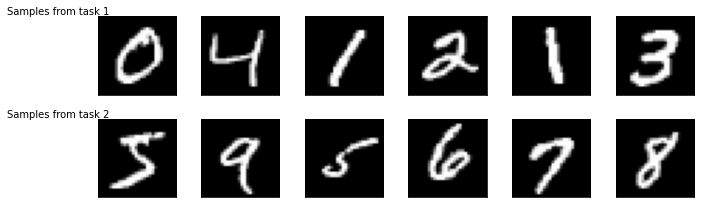

In [4]:
# Creating two tasks
task_classes_arr = [(0, 1, 2, 3, 4), (5, 6, 7, 8, 9)]
tasks_num = len(task_classes_arr) 

task_data = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask] - task_classes[0]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask] - task_classes[0]
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))

# Display tasks
def plot_task(axs, data, samples_num):
  for sample in range(samples_num):
    axs[sample].imshow(data[sample][0], cmap="gray")
    axs[sample].xaxis.set_ticks([])
    axs[sample].yaxis.set_ticks([])

n_tasks, samples = 2, 6
_, axs = plt.subplots(n_tasks, samples, figsize=(10, 3))
for task in range(n_tasks):
  axs[task, 0].set_ylabel(f'Samples from task {task+1}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data[task][0], samples)
plt.tight_layout()

In [5]:
class Base(nn.Module):
  """The base model.
  """
  def __init__(self, hsize=32):
    super(Base, self).__init__()
    self.l1 = nn.Linear(784, hsize)
    
  def forward(self, x, return_z_also=False):
    x = x.view(x.size(0), -1)
    z = self.l1(x)
    if return_z_also:
        return z
    else:
        return z

class Head(nn.Module):
  """The classifier head.
  """
  def __init__(self, fe, hsize=32):
    super(Head, self).__init__()
    self.fe = fe
    self.l2 = nn.Linear(hsize, 5)

  def clf(self, z):
    x = self.l2(F.relu(z))
    return x

  def forward(self, x, return_z_also=False):
    z = self.fe.forward(x)
    x = self.clf(z)
    if return_z_also:
        return x, z
    else:
        return x, z

In [6]:
def train(model, device, train_loader, optimizer, epochs=10, log_training=False):
    for epoch in range(epochs):
      model.train()
      
      for x, y in train_loader:
        x, y = x.to(device), y.to(device).long()
        
        optimizer.zero_grad()

        output, _ = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if log_training:
          print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    accuracy_metric = Metrics()

    for x, y in test_loader:
      with torch.no_grad():
        x, y = x.to(device), y.to(device).long()
        output, _ = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss

        accuracy = compute_accuracy(output, y)[0].item()
        accuracy_metric.update(accuracy)

    test_loss /= len(test_loader)
    return test_loss, accuracy_metric.avg

In [7]:
class Metrics:
    def __init__(self):
        self.val = 0
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count += n
        self.avg = self.sum / self.count
        
def compute_accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    result = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        result.append(correct_k.mul_(100.0 / batch_size))
    return result

def plot_accuracy(y, filename='plot'):
  x = np.array(["Task 1", "Task 2"])
  c = ['#66AA22', '#6495ED']
  plt.ylabel('Accuracy', fontweight='bold', fontsize=20)
  plt.bar(x, y, color=c)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.ylim([0,110])
  plt.grid(b=True, which='major', color='gray', linestyle='-', alpha=0.4)
  plt.grid(b=True, which='minor', color='gray', linestyle='--', alpha=0.1)
  plt.minorticks_on()
  plt.savefig(filename, bbox_inches='tight',pad_inches = 0)
  plt.show()


Training on Task 1
Testing on Task 1: accuracy -> 98.9951058364496


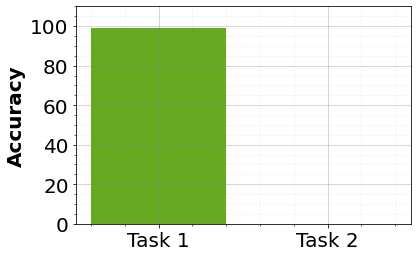

In [8]:
z_size = 32
batch_size = 128

# Creating the models
base_model = Base(hsize=z_size).to(device)
model_t1 = Head(base_model, hsize=z_size).to(device)
model_t2 = Head(base_model, hsize=z_size).to(device)

# Setting up the optimizers
optimizer = optim.SGD(model_t1.parameters(), lr=0.1, momentum=0.9)
x_train_1, t_train_1, x_test_1, t_test_1 = task_data[0]
x_train_2, t_train_2, x_test_2, t_test_2 = task_data[1]

# Setting up data
t1_train_ds = TensorDataset(torch.Tensor(x_train_1), torch.Tensor(t_train_1))
t1_test_ds = TensorDataset(torch.Tensor(x_test_1), torch.Tensor(t_test_1))
t2_train_ds = TensorDataset(torch.Tensor(x_train_2), torch.Tensor(t_train_2))
t2_test_ds = TensorDataset(torch.Tensor(x_test_2), torch.Tensor(t_test_2))
t1_train_loader = DataLoader(t1_train_ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
t1_test_loader = DataLoader(t1_test_ds, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)
t2_train_loader = DataLoader(t2_train_ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
t2_test_loader = DataLoader(t2_test_ds, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=False)

print('Training on Task 1')
train(model_t1, device, t1_train_loader, optimizer, epochs=10)

loss, acc_t1_after_t1 = test(model_t1, device, t1_test_loader)
print(f'Testing on Task 1: accuracy -> {acc_t1_after_t1}')

y = np.array([acc_t1_after_t1, 0])
plot_accuracy(y, 'after_first.pdf')

Training on Task 2
Testing on Task 1 using the backbone features adapted after learning task 2: accuracy -> 22.197930033613996
Testing on Task 2 using model_t2: accuracy -> 95.22730275204307


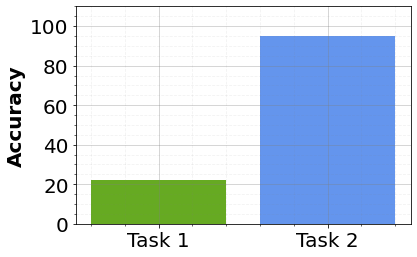

In [9]:
print('Training on Task 2')
train(model_t2, device, t2_train_loader, optimizer, epochs=10)

loss, acc_t1_after_t2 = test(model_t1, device, t1_test_loader)
print(f'Testing on Task 1 using the backbone features adapted after learning task 2: accuracy -> {acc_t1_after_t2}')

loss, acc_t2_after_t2 = test(model_t2, device, t2_test_loader)
print(f'Testing on Task 2 using model_t2: accuracy -> {acc_t2_after_t2}')

y = np.array([acc_t1_after_t2, acc_t2_after_t2])
plot_accuracy(y, 'after_second.pdf')